In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set background and fontsize
rc_params = {
    'pdf.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'ps.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'axes.labelcolor': '#222222',
    'axes.labelsize': 9,
    'text.color': '#222222',
    'font.sans-serif' : 'Helvetica',
    'text.usetex': False,
    'figure.figsize': (7.2, 4.45),
    'xtick.major.size': 0.00,
    'ytick.major.size': 0.00,
    'axes.labelpad': 0.1,
    }
sns.set(style='white', context='paper', rc=rc_params,
        font_scale=1.0)

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

In [3]:
def get_trajectory_direction(linear_distance):
    is_inbound = np.insert(np.diff(linear_distance) < 0, 0, False)
    return np.where(is_inbound, 'Inbound', 'Outbound'), is_inbound

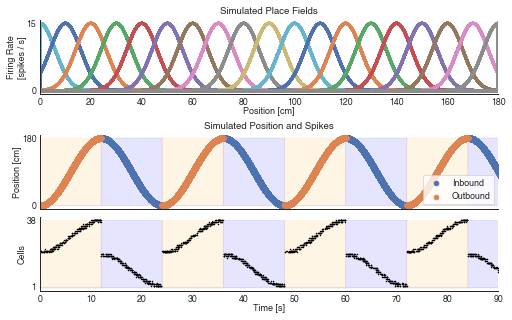

In [4]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data
from replay_trajectory_classification.misc import TWO_COLUMN, GOLDEN_RATIO

time, linear_distance, sampling_frequency, spikes, place_fields = make_simulated_run_data(make_inbound_outbound_neurons=True)
spike_ind, neuron_ind = np.nonzero(spikes)
cmap = plt.get_cmap('tab20')


encoding_labels, is_inbound = get_trajectory_direction(linear_distance)

fig, axes = plt.subplots(3, 1, figsize=(TWO_COLUMN, TWO_COLUMN * GOLDEN_RATIO), constrained_layout=True)
for place_field in place_fields.T:
    axes[0].plot(linear_distance, place_field, linewidth=3)
axes[0].set_xlabel('Position [cm]')
axes[0].set_ylabel('Firing Rate\n[spikes / s]')
axes[0].set_title('Simulated Place Fields')
axes[0].set_xlim((linear_distance.min(), linear_distance.max()))
axes[0].set_yticks([0, np.round(place_fields.max())])

axes[1].scatter(time[encoding_labels == 'Inbound'], linear_distance[encoding_labels == 'Inbound'], label='Inbound')
axes[1].scatter(time[encoding_labels == 'Outbound'], linear_distance[encoding_labels == 'Outbound'], label='Outbound')
axes[1].legend()
axes[1].fill_between(time, is_inbound * linear_distance.max(), alpha=0.1, color='blue', zorder=-1)
axes[1].fill_between(time, ~is_inbound * linear_distance.max(), alpha=0.1, color='orange', zorder=-1)
axes[1].set_ylabel('Position [cm]')
axes[1].set_title('Simulated Position and Spikes')
axes[1].set_yticks([0, np.round(linear_distance.max())])
axes[1].set_xticks([])
axes[1].set_xlim((0.0, 90.0))

n_neurons = spikes.shape[1]
axes[2].scatter(time[spike_ind], neuron_ind + 1, c='black', s=0.5)
axes[2].set_yticks((1, n_neurons))
axes[2].set_ylabel('Cells')
axes[2].fill_between(time, is_inbound * n_neurons, alpha=0.1, color='blue', zorder=-1)
axes[2].fill_between(time, ~is_inbound * n_neurons, alpha=0.1, color='orange', zorder=-1)
axes[2].set_xlabel('Time [s]')
axes[2].set_xlim((0.0, 90.0))

sns.despine()

In [5]:
from dask.distributed import Client

Client(n_workers=2,
       threads_per_worker=2,
       processes=True,
       memory_limit='25GB')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:59232/status,
Dashboard: http://127.0.0.1:59232/status,Workers: 2
Total threads: 4,Total memory: 46.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59234,Workers: 2
Dashboard: http://127.0.0.1:59232/status,Total threads: 4
Started: Just now,Total memory: 46.57 GiB
Comm: tcp://127.0.0.1:59242,Total threads: 2
Dashboard: http://127.0.0.1:59243/status,Memory: 23.28 GiB
Nanny: tcp://127.0.0.1:59237,


In [6]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var

continuous_transition_types = [['random_walk_direction1', 'random_walk',            'uniform', 'random_walk',            'random_walk',            'uniform'],
                               ['random_walk',            'random_walk_direction2', 'uniform', 'random_walk',            'random_walk',            'uniform'],
                               ['uniform',                'uniform',                'uniform', 'uniform',                'uniform',                'uniform'],
                               ['random_walk',            'random_walk',            'uniform', 'random_walk_direction2', 'random_walk',            'uniform'],
                               ['random_walk',            'random_walk',            'uniform', 'random_walk',            'random_walk_direction1', 'uniform'],
                               ['uniform',                'uniform',                'uniform', 'uniform',                'uniform',                'uniform'],
                               ]
encoding_group_to_state = ['Inbound', 'Inbound', 'Inbound', 'Outbound', 'Outbound', 'Outbound']


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

classifier = SortedSpikesClassifier(movement_var=movement_var,
                                    replay_speed=120,
                                    spike_model_penalty=0.5,
                                    place_bin_size=np.sqrt(movement_var),
                                    continuous_transition_types=continuous_transition_types,
                                    discrete_transition_diag=0.99)
classifier.fit(
    linear_distance,
    spikes,
    encoding_group_labels=encoding_labels,
    encoding_group_to_state=encoding_group_to_state)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
/Users/pho/opt/anaconda3/lib/python3.8/site-packages/regularized_glm/core.py:83: RuntimeWarning: divide by zero encountered in true_divide
  weights = prior_weights / (family.variance(predicted_response)
/Users/pho/opt/anaconda3/lib/python3.8/site-packages/regularized_glm/core.py:83: RuntimeWarning: divide by zero encountered in true_divide
  weights = prior_weights / (family.variance(predicted_response)



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.
Weighted least squares failed. Returning NaN coefficiients.
/Users/pho/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:428: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/Users/pho/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning: divide by zero encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/Users/pho/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning: invalid value encountered in multiply
  return var_weights / scale * (endog * np.log(mu) - mu -
/Users/pho/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:428: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/Users/pho/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/family.


Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.
Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.
Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.
Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.
Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.
Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.
Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.


SortedSpikesClassifier(continuous_transition_types=[['random_walk_direction1',
                                                     'random_walk', 'uniform',
                                                     'random_walk',
                                                     'random_walk', 'uniform'],
                                                    ['random_walk',
                                                     'random_walk_direction2',
                                                     'uniform', 'random_walk',
                                                     'random_walk', 'uniform'],
                                                    ['uniform', 'uniform',
                                                     'uniform', 'uniform',
                                                     'uniform', 'uniform'],
                                                    ['random_walk',
                                                     'random_walk', 'uniform',
               

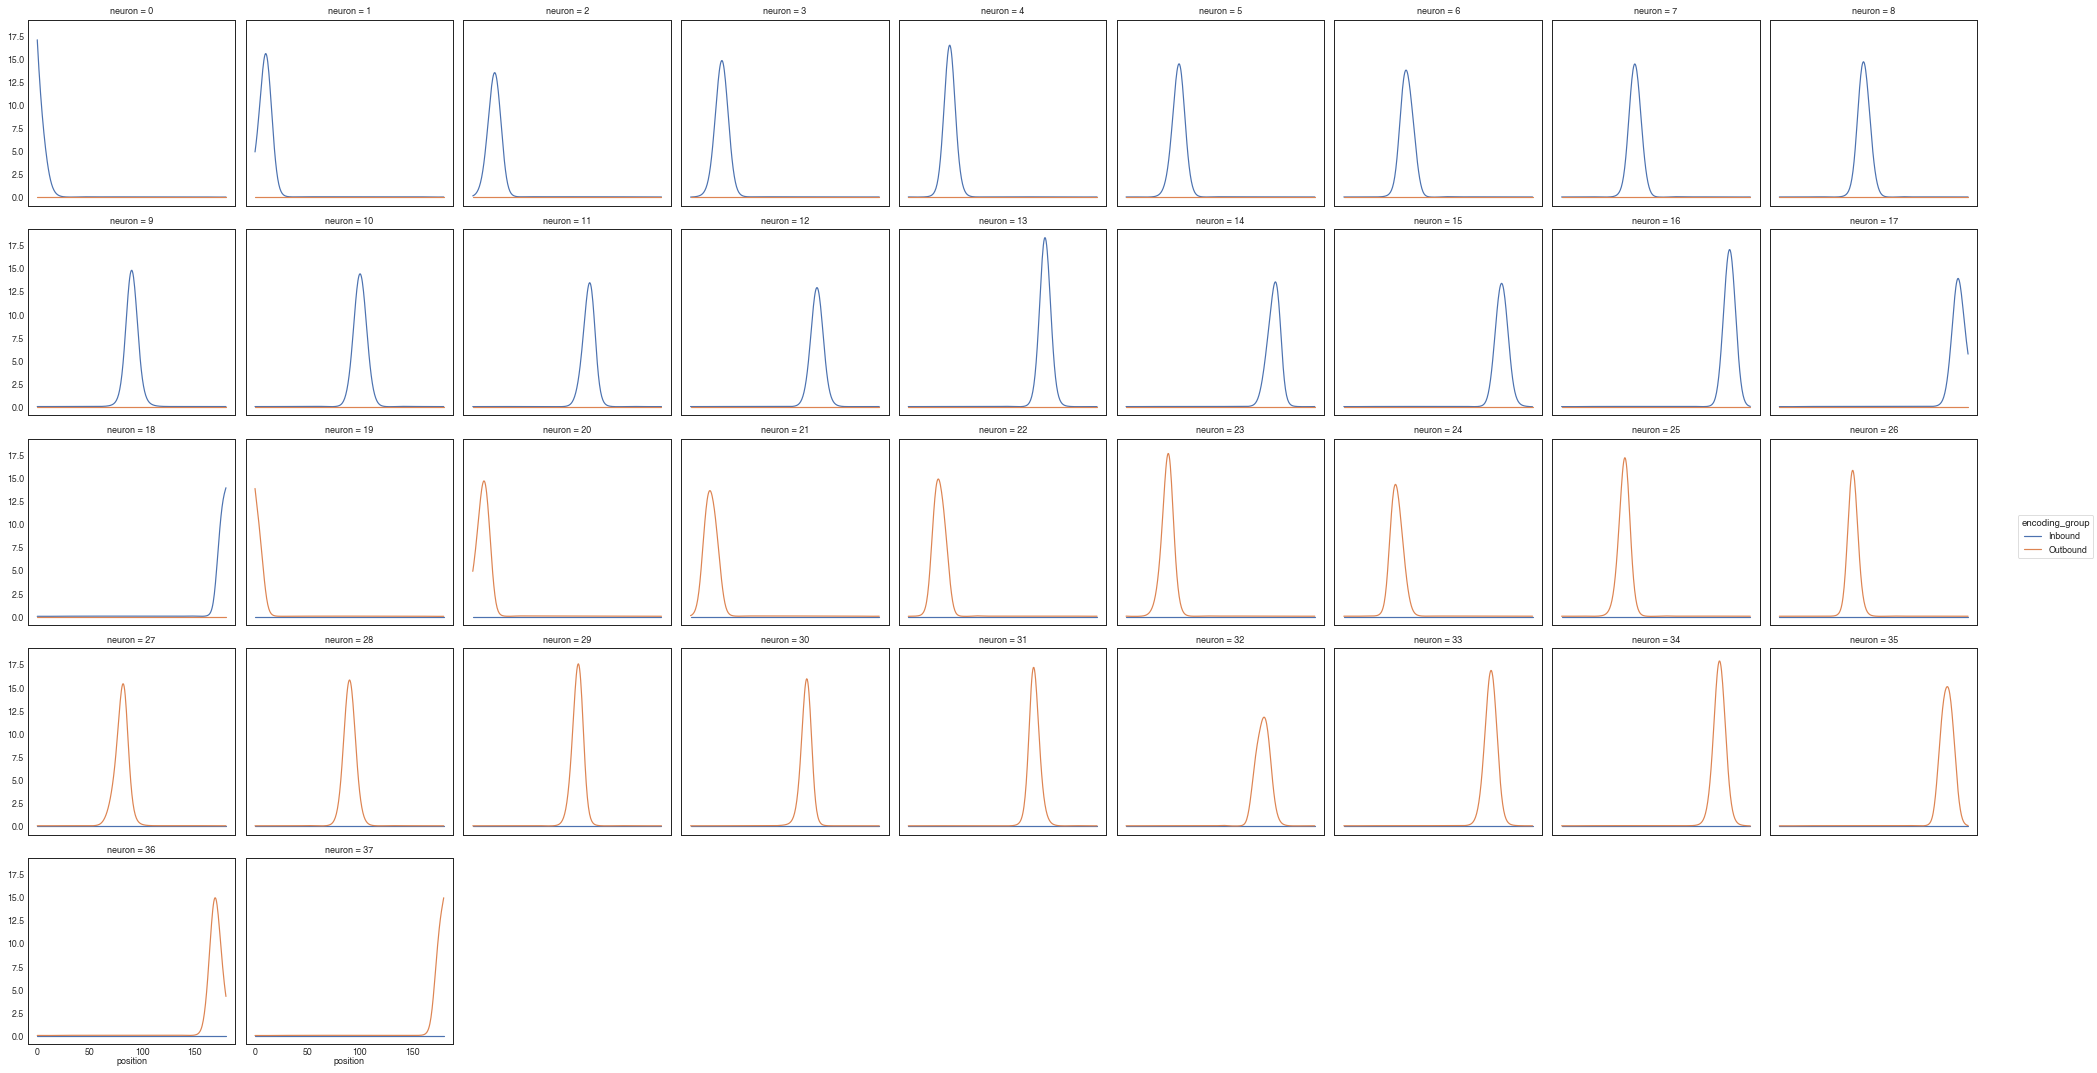

In [7]:
g = (classifier.place_fields_ * sampling_frequency).plot(x='position', col='neuron', hue='encoding_group', 
                                                         col_wrap=9)

In [8]:
def plot_classification(replay_time, test_spikes, results, posterior_type='acausal_posterior'):
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
    spike_time_ind, neuron_ind = np.nonzero(test_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                    marker='|', s=80, linewidth=3, clip_on=False)
    
    n_neurons = test_spikes.shape[1]
    axes[0].axhspan(0.0, n_neurons//2, color='blue', zorder=-1, alpha=0.1)
    axes[0].axhspan(n_neurons//2, n_neurons, color='orange', zorder=-1, alpha=0.1)
    axes[0].set_ylim((0, n_neurons))
    axes[0].set_yticks((0,  n_neurons))
    axes[0].set_ylabel('Neuron Index')

    replay_probability = results[posterior_type].sum('position')
    for state, prob in replay_probability.groupby('state'):
        axes[1].plot(prob.time, prob.values, linewidth=2, label=state)
    axes[1].set_ylabel('Probability')
    axes[1].set_yticks([0, 1])
    axes[1].set_ylim((-0.01, 1.05))
    axes[1].legend()
    
    results[posterior_type].sum('state').plot(
        x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    axes[2].set_ylabel('Position [cm]')
    plt.xlim((replay_time.min(), replay_time.max()))
    axes[-1].set_xlabel('Time [ms]')
    sns.despine(offset=5)

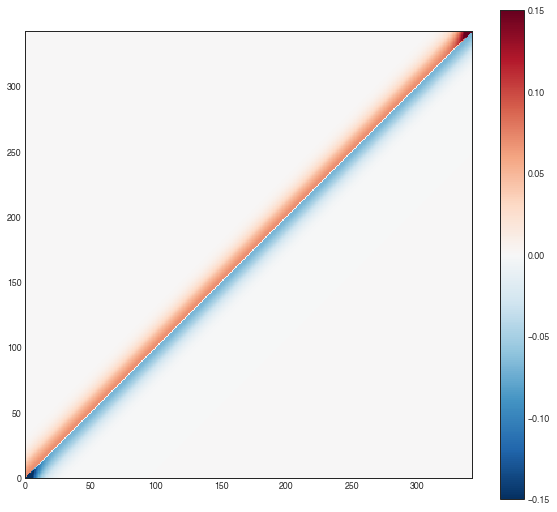

In [9]:
plt.figure(figsize=(10, 9))
plt.pcolormesh((classifier.continuous_state_transition_[0, 0] - classifier.continuous_state_transition_[3, 3] ).T,
               cmap='RdBu_r', vmax=0.15, vmin=-0.15)
plt.axis('square')
plt.colorbar()

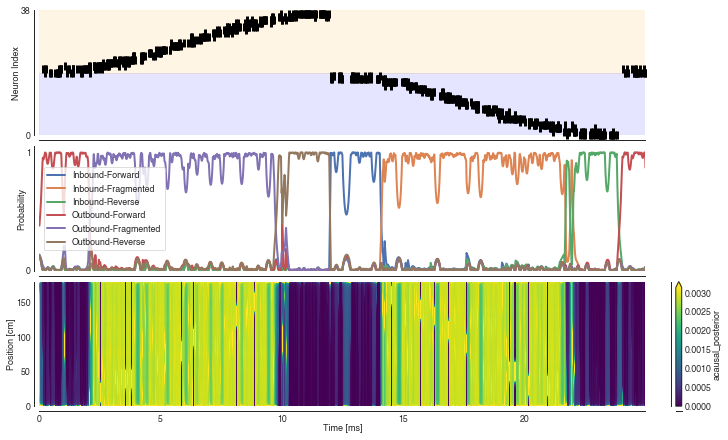

In [10]:
state_names = ['Inbound-Forward', 'Inbound-Reverse', 'Inbound-Fragmented',
               'Outbound-Forward', 'Outbound-Reverse', 'Outbound-Fragmented']

results = classifier.predict(spikes[:25_000], time=time[:25_000], state_names=state_names)
plot_classification(time[:25_000], spikes[:25_000], results, posterior_type='acausal_posterior')

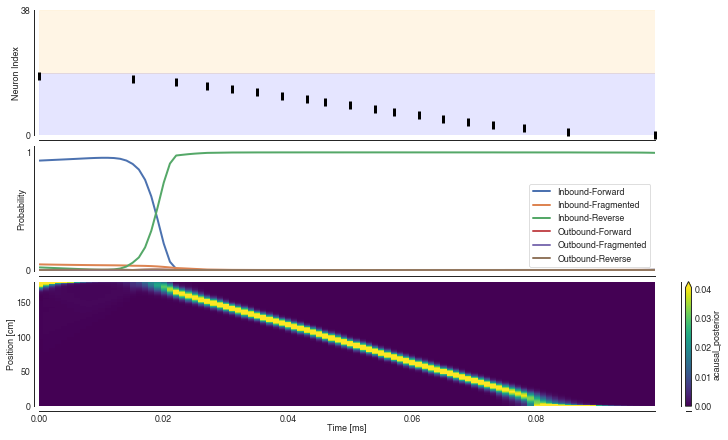

In [11]:
from replay_trajectory_classification.sorted_spikes_simulation import make_continuous_replay

replay_time, test_spikes = make_continuous_replay(is_outbound=False)
test_spikes = np.concatenate((test_spikes, np.zeros_like(test_spikes)), axis=1)
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results, posterior_type='acausal_posterior')

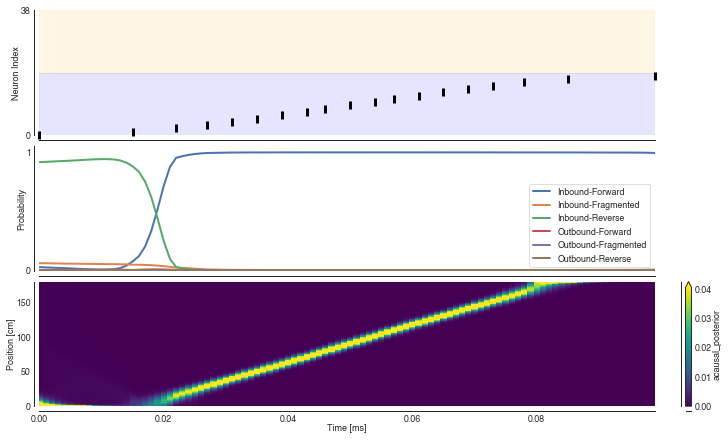

In [12]:

replay_time, test_spikes = make_continuous_replay(is_outbound=True)
test_spikes = np.concatenate((test_spikes, np.zeros_like(test_spikes)), axis=1)
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results, posterior_type='acausal_posterior')

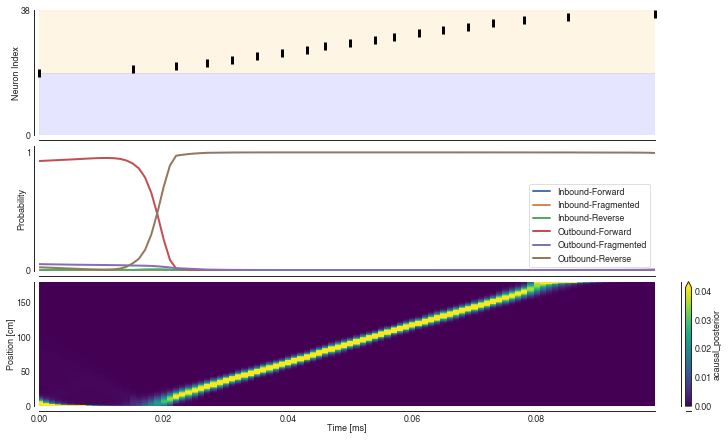

In [13]:
replay_time, test_spikes = make_continuous_replay(is_outbound=True)
test_spikes = np.concatenate((np.zeros_like(test_spikes), test_spikes), axis=1)
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results, posterior_type='acausal_posterior')

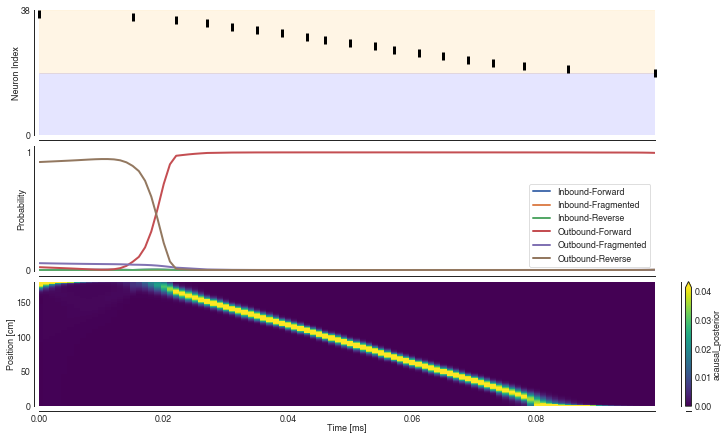

In [14]:
replay_time, test_spikes = make_continuous_replay(is_outbound=False)
test_spikes = np.concatenate((np.zeros_like(test_spikes), test_spikes), axis=1)
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results, posterior_type='acausal_posterior')

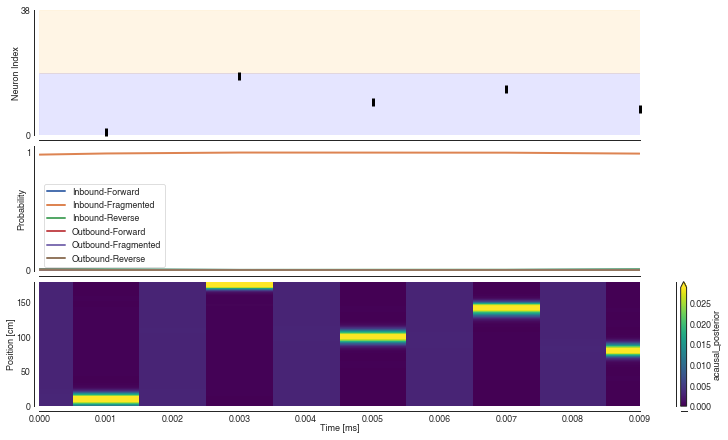

In [15]:
from replay_trajectory_classification.sorted_spikes_simulation import make_fragmented_replay

replay_time, test_spikes = make_fragmented_replay()
test_spikes = np.concatenate((test_spikes, np.zeros_like(test_spikes)), axis=1)
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

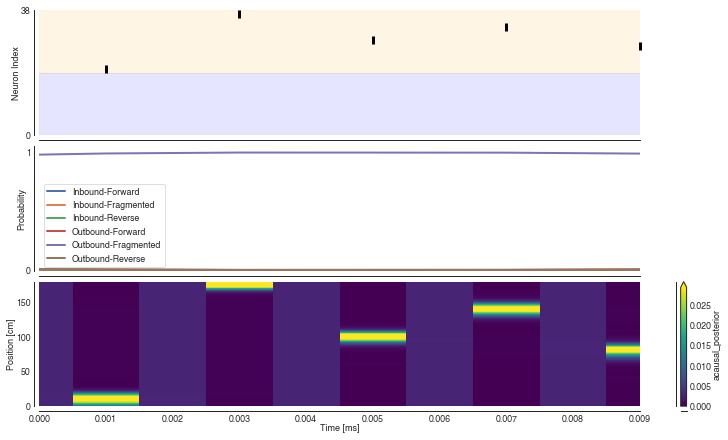

In [16]:
replay_time, test_spikes = make_fragmented_replay()
test_spikes = np.concatenate((np.zeros_like(test_spikes), test_spikes), axis=1)
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

## Clusterless

(0.0, 349.999)

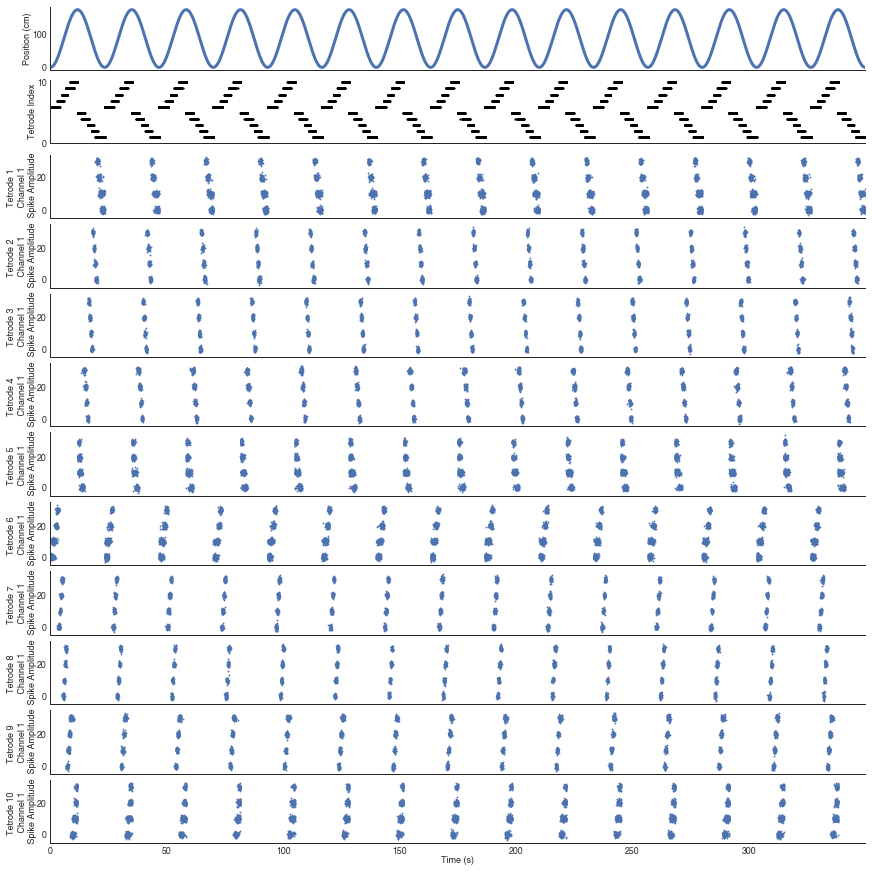

In [17]:
from replay_trajectory_classification.clusterless_simulation import make_simulated_run_data

(time, linear_distance, sampling_frequency,
 multiunits, multiunits_spikes) = make_simulated_run_data(make_inbound_outbound_neurons=True)

spike_ind, neuron_ind = np.nonzero(multiunits_spikes)
n_tetrodes = multiunits.shape[-1]

fig, axes = plt.subplots(n_tetrodes + 2, 1, figsize=(12, 12), constrained_layout=True, sharex=True)
axes[0].plot(time, linear_distance, linewidth=3)
axes[0].set_ylabel('Position (cm)')

axes[1].scatter(time[spike_ind], neuron_ind + 1, color='black', s=2)
axes[1].set_yticks((0, multiunits_spikes.shape[1]))
axes[1].set_ylabel('Tetrode Index')

for tetrode_ind in range(n_tetrodes):
    axes[2 + tetrode_ind].scatter(time, multiunits[:, 0, tetrode_ind], s=1)
    axes[2 + tetrode_ind].set_ylabel(f'Tetrode {tetrode_ind + 1} \n Channel 1 \n Spike Amplitude')

sns.despine()
axes[-1].set_xlabel('Time (s)')
axes[-1].set_xlim((time.min(), time.max()))

In [18]:
encoding_labels, is_inbound = get_trajectory_direction(linear_distance)

In [19]:
from replay_trajectory_classification import ClusterlessClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.misc import NumbaKDE

movement_var = estimate_movement_var(linear_distance, sampling_frequency)
model = NumbaKDE
model_kwargs = {
    'bandwidth': np.array([1.0, 1.0, 1.0, 1.0, 12.5, 12.5])
    }
continuous_transition_types = [['random_walk_direction1', 'random_walk',            'uniform', 'random_walk',            'random_walk',            'uniform'],
                               ['random_walk',            'random_walk_direction2', 'uniform', 'random_walk',            'random_walk',            'uniform'],
                               ['uniform',                'uniform',                'uniform', 'uniform',                'uniform',                'uniform'],
                               ['random_walk',            'random_walk',            'uniform', 'random_walk_direction2', 'random_walk',            'uniform'],
                               ['random_walk',            'random_walk',            'uniform', 'random_walk',            'random_walk_direction1', 'uniform'],
                               ['uniform',                'uniform',                'uniform', 'uniform',                'uniform',                'uniform'],
                               ]
encoding_group_to_state = ['Inbound', 'Inbound', 'Inbound', 'Outbound', 'Outbound', 'Outbound']


classifier = ClusterlessClassifier(movement_var=movement_var,
                                   replay_speed=120,
                                   place_bin_size=np.sqrt(movement_var),
                                   model=model,
                                   model_kwargs=model_kwargs,
                                   continuous_transition_types=continuous_transition_types,
                                   discrete_transition_diag=0.99)
classifier.fit(linear_distance,
               multiunits,
               encoding_group_labels=encoding_labels,
               encoding_group_to_state=encoding_group_to_state)

TypeError: __init__() got an unexpected keyword argument 'model'

In [ ]:
def plot_classification(replay_time, test_multiunits, results):
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), constrained_layout=True, sharex=True)
    test_multiunit_spikes = np.any(~np.isnan(test_multiunits), axis=1)
    spike_time_ind, neuron_ind = np.nonzero(test_multiunit_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black')
    axes[0].set_yticks((0, test_multiunit_spikes.shape[1]))
    axes[0].set_ylabel('Tetrode Index')
    
    replay_probabilities = results.acausal_posterior.sum('position')
    for state, probability in replay_probabilities.groupby('state'):
        probability.plot(x='time', linewidth=2, ax=axes[1], label=state)
    axes[1].set_ylabel('Probability')
    axes[1].set_ylim((0.0, 1.05))
    axes[1].set_title("")
    axes[1].legend()
    
    results.acausal_posterior.sum('state').plot(
            x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    plt.xlim((replay_time.min(), replay_time.max()))
    sns.despine()

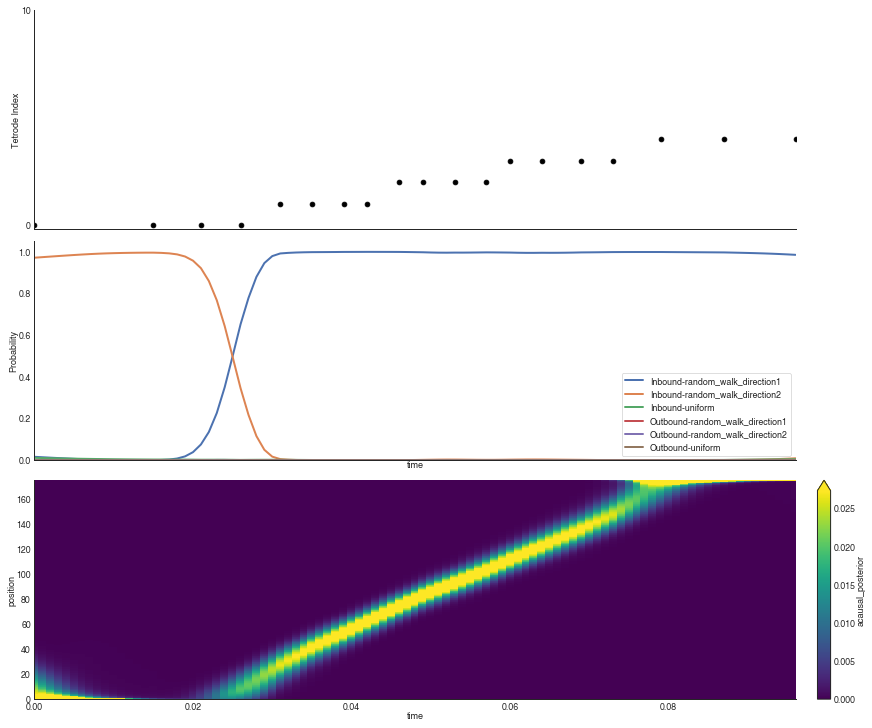

In [ ]:
from replay_trajectory_classification.clusterless_simulation import make_continuous_replay

replay_time, test_multiunits = make_continuous_replay()
test_multiunits = np.concatenate((test_multiunits, np.full_like(test_multiunits, np.nan)), axis=-1)
results = classifier.predict(test_multiunits, time=replay_time)
plot_classification(replay_time, test_multiunits, results)

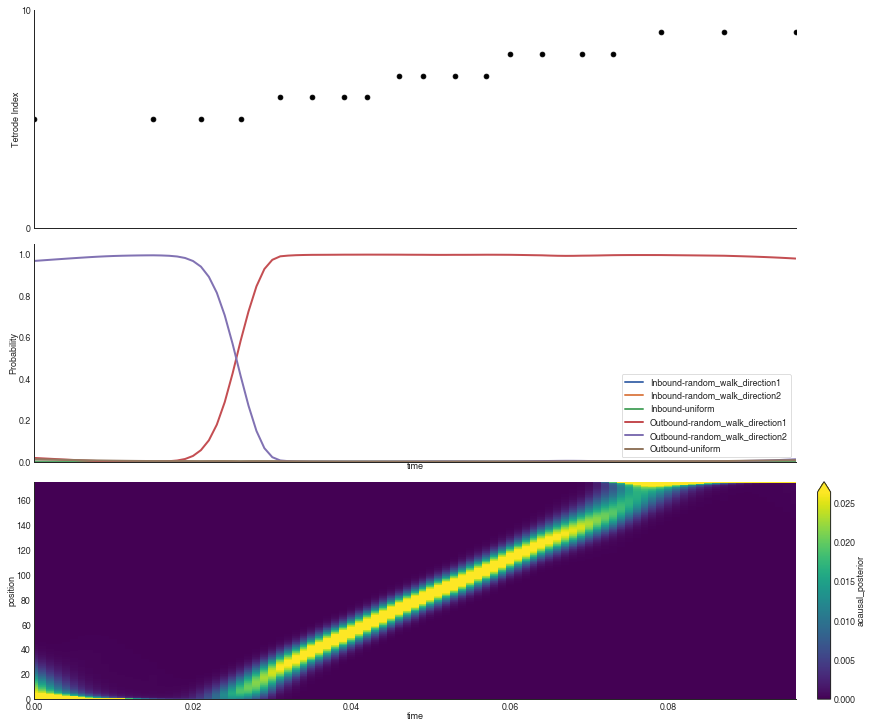

In [ ]:
from replay_trajectory_classification.clusterless_simulation import make_continuous_replay

replay_time, test_multiunits = make_continuous_replay()
test_multiunits = np.concatenate((np.full_like(test_multiunits, np.nan), test_multiunits), axis=-1)
results = classifier.predict(test_multiunits, time=replay_time)
plot_classification(replay_time, test_multiunits, results)

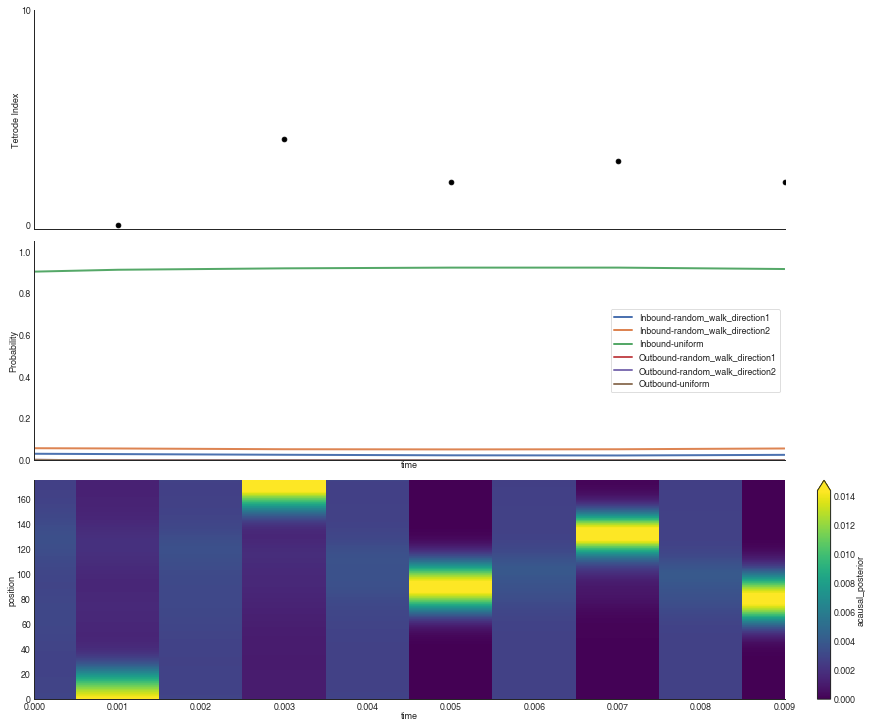

In [ ]:
from replay_trajectory_classification.clusterless_simulation import make_fragmented_replay

replay_time, test_multiunits = make_fragmented_replay()
test_multiunits = np.concatenate((test_multiunits, np.full_like(test_multiunits, np.nan)), axis=-1)
results = classifier.predict(test_multiunits, time=replay_time)
plot_classification(replay_time, test_multiunits, results)

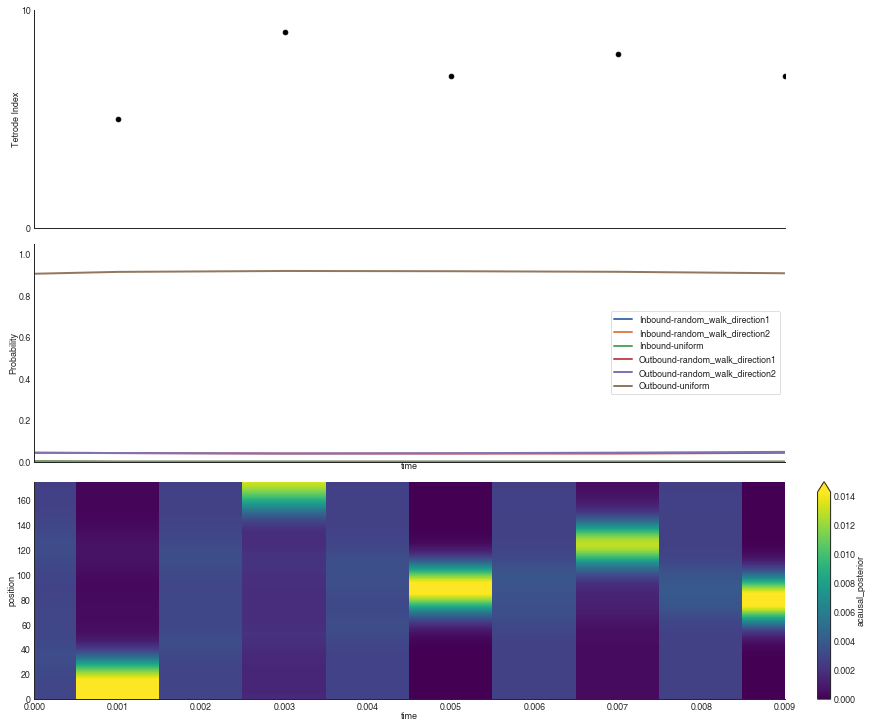

In [ ]:
from replay_trajectory_classification.clusterless_simulation import make_fragmented_replay

replay_time, test_multiunits = make_fragmented_replay()
test_multiunits = np.concatenate((np.full_like(test_multiunits, np.nan), test_multiunits), axis=-1)
results = classifier.predict(test_multiunits, time=replay_time)
plot_classification(replay_time, test_multiunits, results)